# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [2]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 2

We'll need an OpenAI API Key:

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 9a658345


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [6]:
from google.colab import files
uploaded = files.upload()

Saving 2106.09685v2.pdf to 2106.09685v2.pdf


In [7]:
file_path = list(uploaded.keys())[0]
file_path

'2106.09685v2.pdf'

We'll define our chunking strategy.

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [9]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [10]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
import uuid

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

- Cache Size & Management:
  - Caching embeddings can quickly consume storage space, especially when handling a large number of documents or large embeddings (text-embedding-3-small is with 1536 dimensions). If the cache is not properly managed it could lead to excessive storage use or even disk space exhaustion.

- In-memory Qdrant Client:
  - We're using an in-memory Qdrant client. This approach limits scalability and persistence, as all data is lost when the process terminates.

- We can also add query cache which would store the results of specific queries (e.g., "return the top 3 documents relevant to this query") so that if the same query is repeated, the system can return the cached result without having to perform the search again.

- it is most useful where documents do not frequently change. Once the embeddings are cached, retrieval operations are faster, and the cost of computing embeddings is minimized.

- If documents are frequently updated or added, the cache becomes less useful since embeddings will need to be recomputed frequently, and the overhead of cache management might outweigh the benefits. If the document collection is small and embedding computation is fast, caching may not provide significant performance gains. I

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
import time

# Case 1: Without Cache
def embed_without_cache(docs):
    core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    start_time = time.time()
    embeddings = [core_embeddings.embed_documents([doc.page_content]) for doc in docs]
    end_time = time.time()
    print(f"Time without cache: {end_time - start_time} seconds")
    return embeddings

# Case 2: With Cache
def embed_with_cache(docs, store):
    core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    cached_embedder = CacheBackedEmbeddings.from_bytes_store(core_embeddings, store, namespace=core_embeddings.model)

    start_time = time.time()
    embeddings = [cached_embedder.embed_documents([doc.page_content]) for doc in docs]
    end_time = time.time()
    print(f"Time with cache: {end_time - start_time} seconds")
    return embeddings

# Example usage:
import os
from langchain.storage import LocalFileStore

# Create some sample documents
sample_docs = docs  # Assume `docs` from your original code

# Create a file store for caching
cache_dir = "./cache/"
os.makedirs(cache_dir, exist_ok=True)
store = LocalFileStore(cache_dir)

# Run the test without cache
em1 = embed_without_cache(docs)

# Run the test with cache
em2 = embed_with_cache(docs, store)



Time without cache: 24.552898406982422 seconds
Time with cache: 0.09751653671264648 seconds


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [11]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [12]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [13]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

Prompt caches store a fixed result for a given prompt and context. If the underlying context (such as the set of documents or real-time information) changes, the cached prompt response may become outdated.

One of the main challenges with caching LLM prompts is ensuring that the cache remains fresh and relevant. Over time, the inputs that generate the prompt or the model’s understanding of the world may change, but without a proper cache invalidation strategy, the system could return stale results.

It is useful when during development, when we are iterating on queries and retrieval strategies, caching can speed up the testing process by avoiding repeated computations of embeddings and prompts. I feel it's most effective when the same or very similar prompts are frequently used.

It is less usefull when our queries tend to be highly unique or are rarely repeated, caching will offer minimal benefit since each new query will require fresh embeddings or prompts, and you won’t benefit much from previously cached data

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
### YOUR CODE HERE

set_llm_cache(None)
start_time = time.time()
response = retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
end_time = time.time()
print(f"Time taken (no cache): {end_time - start_time:.4f} seconds")

Time taken (no cache): 13.2840 seconds


In [ ]:
set_llm_cache(InMemoryCache())
start_time = time.time()
response = retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
end_time = time.time()
print(f"Time taken (with cache): {end_time - start_time:.4f} seconds")

Time taken (with cache): 0.4132 seconds


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [14]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [16]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is in PDF format, specifically PDF 1.5.\n2. It was created using LaTeX with hyperref.\n3. The producer of the document is pdfTeX version 1.40.21.\n4. The creation date of the document is October 19, 2021.\n5. The modification date is also October 19, 2021.\n6. The document contains 26 total pages.\n7. It has metadata fields such as source, file path, and collection name.\n8. The document includes references to various authors and their works.\n9. It discusses challenges in generating text from RDF data.\n10. The document refers to a specific conference: the 10th International Conference on Natural Language Generation.\n11. It mentions a table of parameters related to different adaptation methods for GPT-2.\n12. The document evaluates the performance of various models using BLEU, MET, and TER metrics.\n13. It includes comparisons of fine-tuning methods for GPT-2 models.\n14. Parameters in the table show performance results for different model sizes (e.

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

Without Cache:
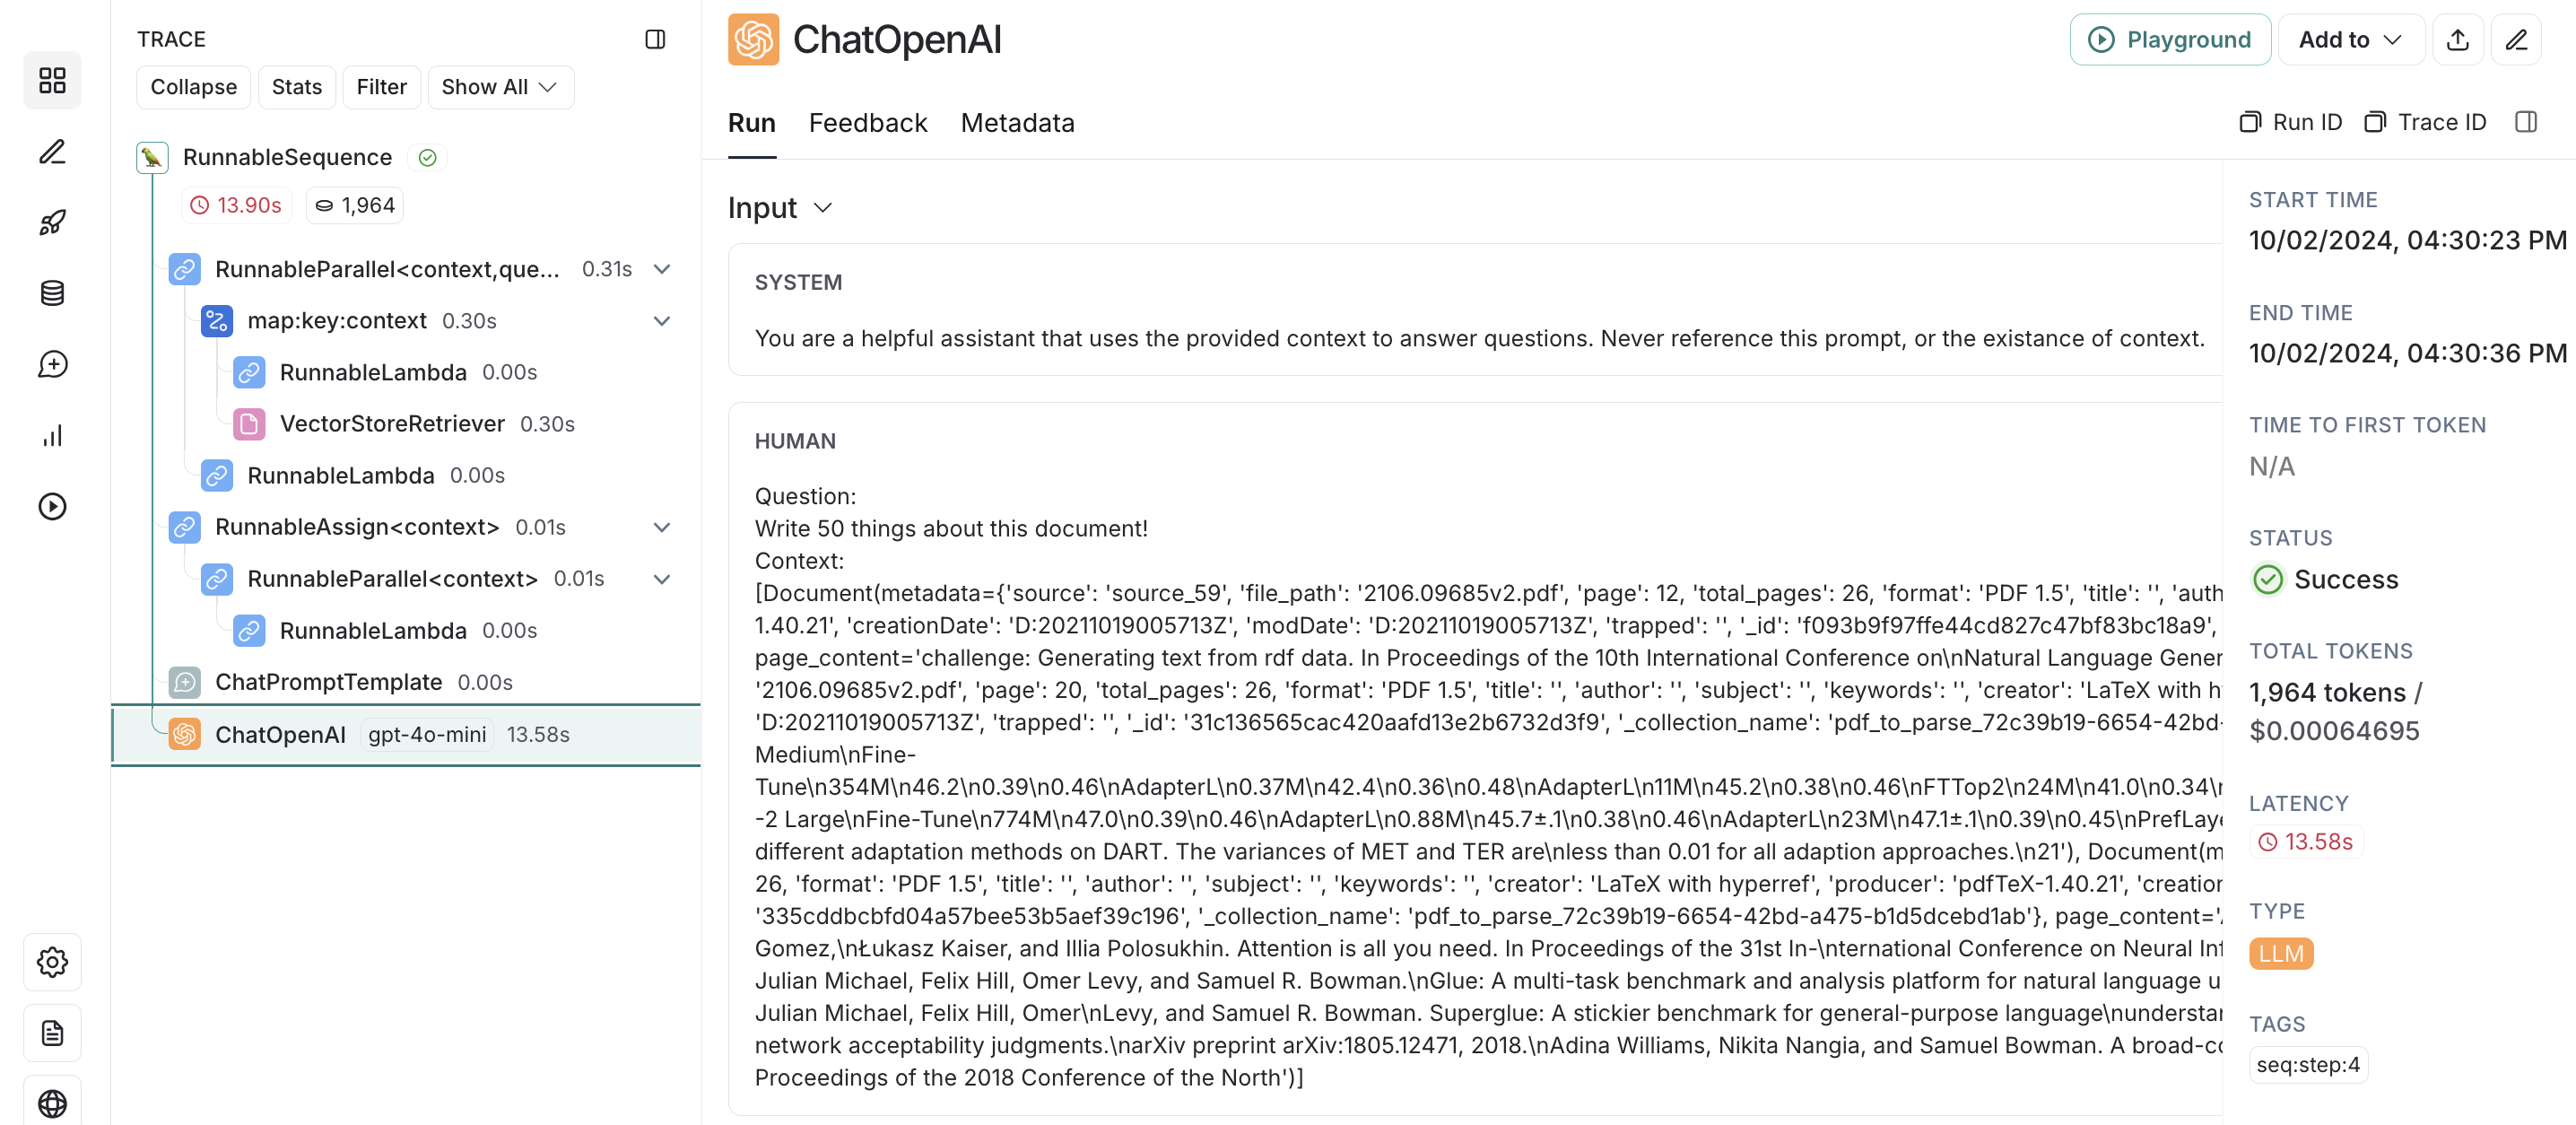

With Cache:
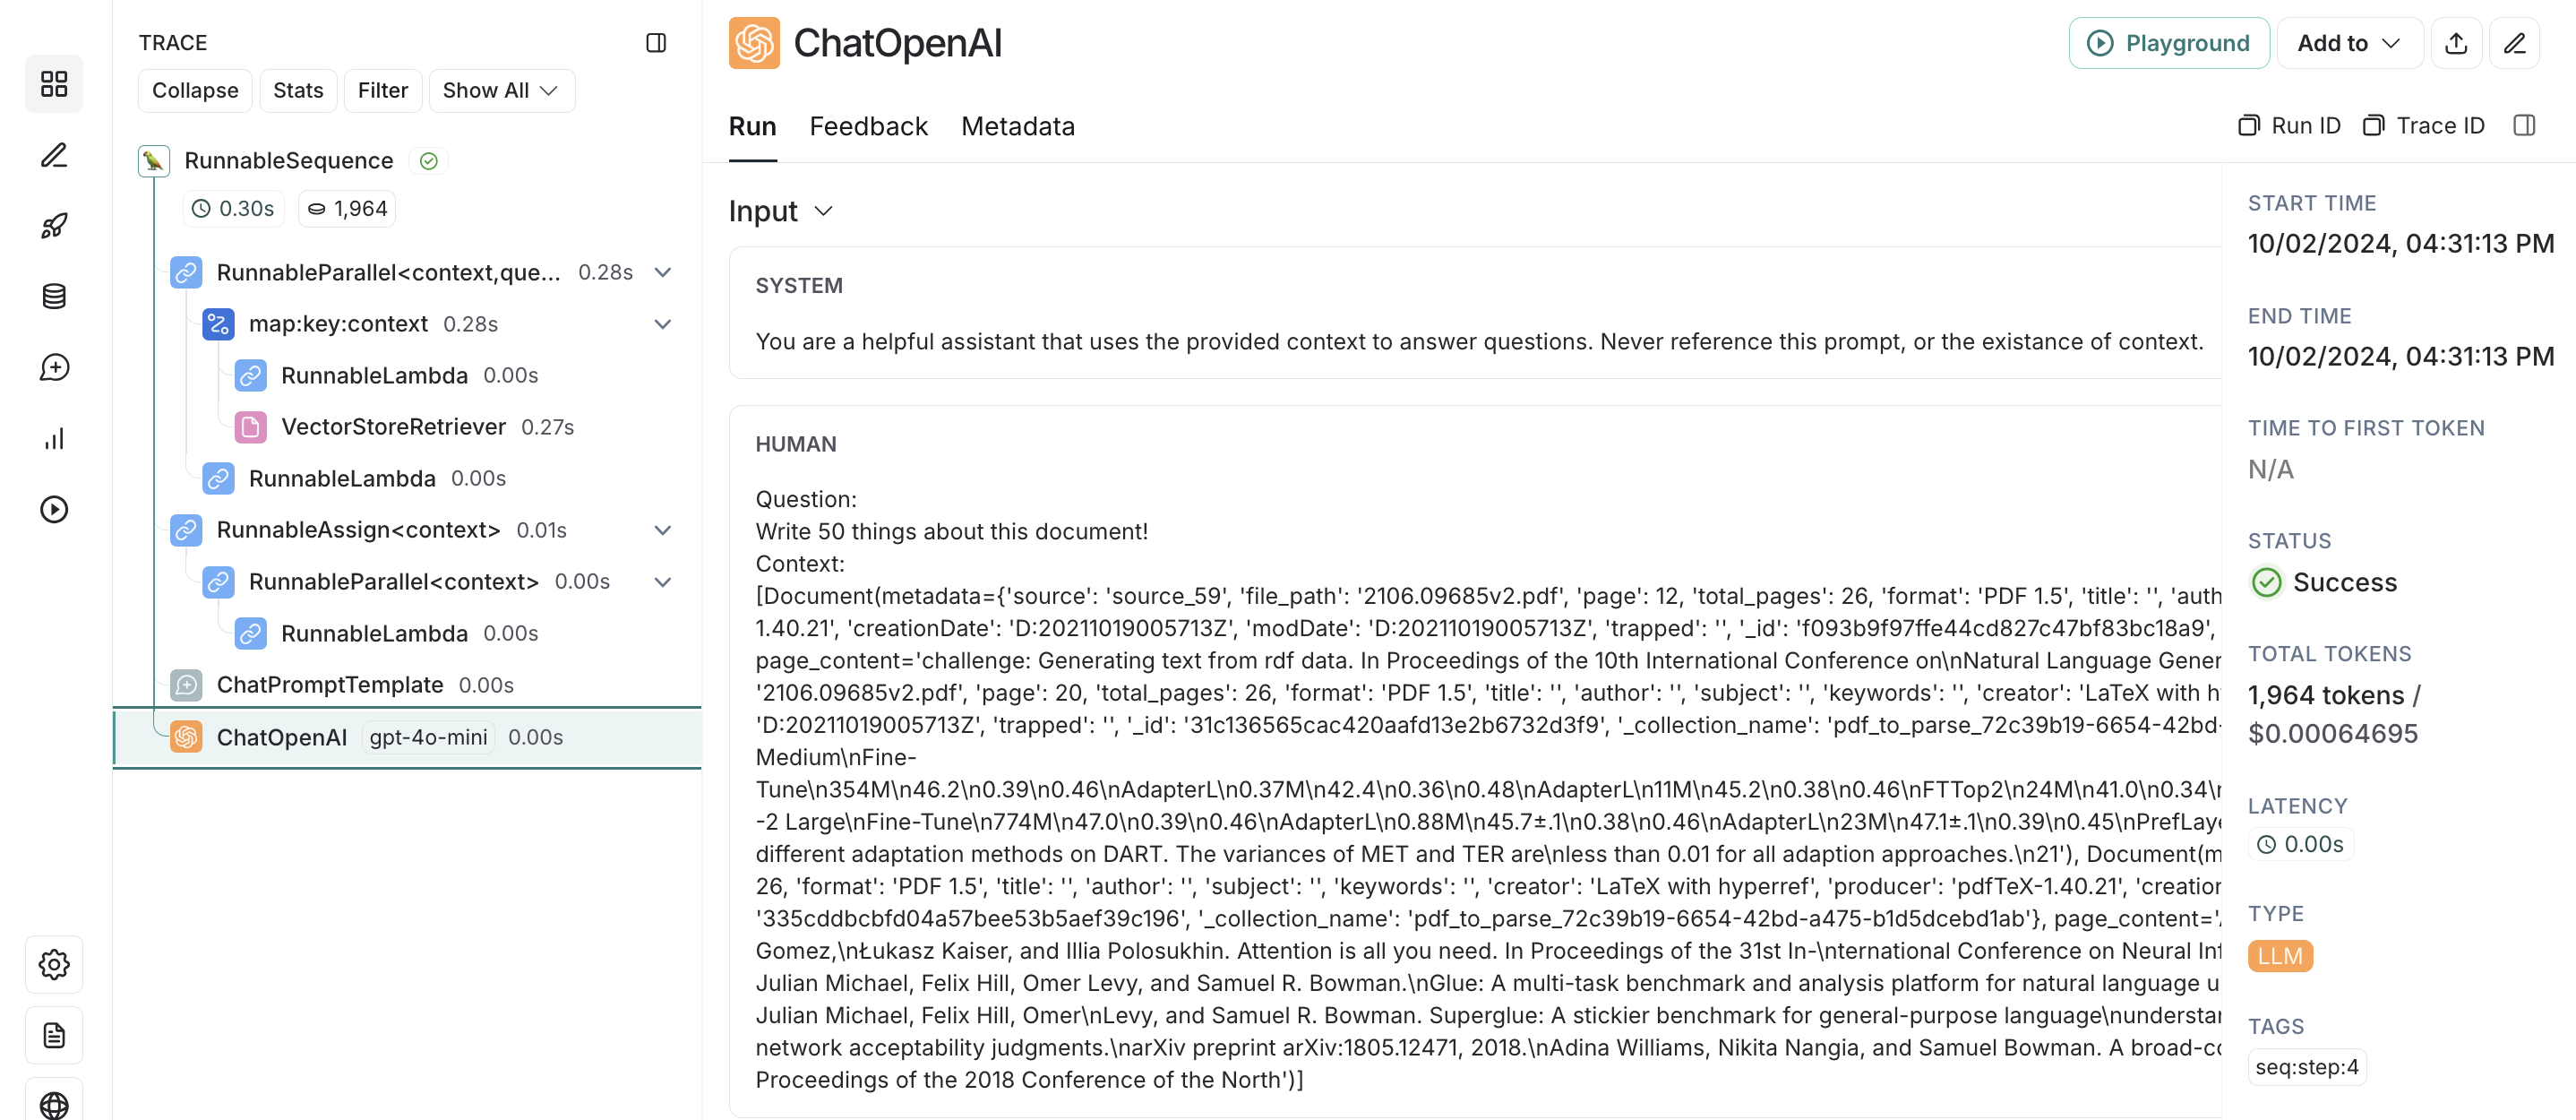